## Assumptions:

* Total Flood Risk = Perc_Cropland_Flooded * 0.5 + Perc_People_Flooded * 0.5


## Hypothesis:

Remotely-sensed flood information, when provided to first responders...reduces food insecurity in the **flood-prone regions of Ghana** relative to **the non-flood-prone regions.**


In [1]:
import pandas as pd

## load in People Recurrence Data

path_input_people = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/People/Output/'
name_input_file_people = 'District_Flood_Risk_Classification_People.csv'

## load in Cropland Recurrence Data

path_input_crops = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/Crops/Output/'
name_input_file_crops = 'District_Flood_Risk_Classification_Crops.csv'

## output files
path_output = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/01-TC-Assignment/'
name_output_file = 'Adm2_TC_Assignment_Recurrence.csv'

In [2]:
# read in and merge data together ---
people = pd.read_csv(path_input_people+name_input_file_people, header=0)
crops = pd.read_csv(path_input_crops+name_input_file_crops, header=0)
#flooded_area = pd.read_csv(path_input_flooded_area+name_input_file_flooded_area, header=0)
# markets = pd.read_csv(path_input_markets+name_input_file_markets, header=0)
# roads = pd.read_csv(path_input_roads+name_input_file_roads, header=0)

tot_flood_risk = people.merge(crops, on='Region')
# tot_flood_risk = tot_flood_risk.merge(flooded_area, on='Region')
# tot_flood_risk = tot_flood_risk.merge(markets, on='Region')
# tot_flood_risk = tot_flood_risk.merge(roads, on='Region')


In [3]:
import numpy as np

# ASSUMPTIONS -----------------

treatment_control_cutoff = 0.50 # percentile threshold above which districts belong to treatment group

cropland_weights = 1
people_weights = 1
flood_area_weights = 0

print('Treatment cutoff assigned: Districts in the', str(int(treatment_control_cutoff*100))+'th percentile and above w.r.t. total flood risk')
print('Weights assigned - cropland: ', str(cropland_weights))
print('Weights assigned - people: ', str(people_weights))

# apply risk formula ----------------

tot_flood_risk['Risk'] = pd.Series((np.array(tot_flood_risk['Avg Impact Per Year - People']) * people_weights) + 
                                   (np.array(tot_flood_risk['Avg Impact Per Year - Crops']) * cropland_weights))

tot_flood_risk['Risk_Norm'] = (tot_flood_risk['Risk'] - tot_flood_risk['Risk'].mean())/(tot_flood_risk['Risk'].std())

tot_flood_risk = tot_flood_risk.sort_values(by='Risk_Norm', ascending=False)

# generate boolean treatment-control assignment variable to use moving forward ----

tot_flood_risk['Treatment'] = None
n_treatment = round(len(tot_flood_risk) * treatment_control_cutoff)
tot_flood_risk.loc[tot_flood_risk.index[0:n_treatment], 'Treatment'] = 1
tot_flood_risk.loc[tot_flood_risk.index[n_treatment:len(tot_flood_risk)], 'Treatment'] = 0

# assert to ensure all districts were assigned to treatment vs control
assert tot_flood_risk.groupby('Treatment').size()[0]+tot_flood_risk.groupby('Treatment').size()[1] == len(tot_flood_risk)
print(tot_flood_risk.groupby('Treatment').size())

# write file to disk ----
#tot_flood_risk.to_csv(path_output+name_output_file, index=False)

Treatment cutoff assigned: Districts in the 50th percentile and above w.r.t. total flood risk
Weights assigned - cropland:  1
Weights assigned - people:  1
Treatment
0    108
1    108
dtype: int64


Text(0.5, 0, 'Normalized Flood Risk Index')

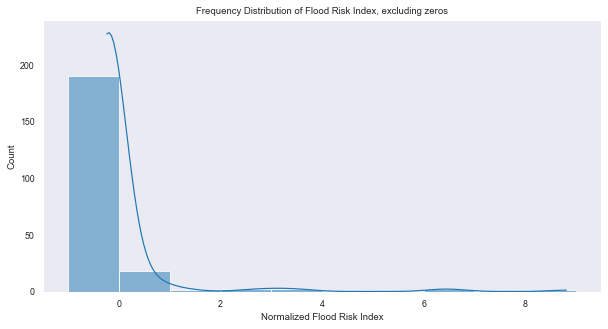

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper")
sns.set_style("dark")

## Histogram of Flood Risk Index values (Normalized)
fig, ax = plt.subplots(figsize=(10,5)) # initialize figure and figure size
ax = sns.histplot(data=tot_flood_risk,
                  x="Risk_Norm", binwidth=1, binrange=(-1,9), stat='count', palette='spectral', kde=True) # plot

plt.title('Frequency Distribution of Flood Risk Index, excluding zeros')
plt.xlabel('Normalized Flood Risk Index')


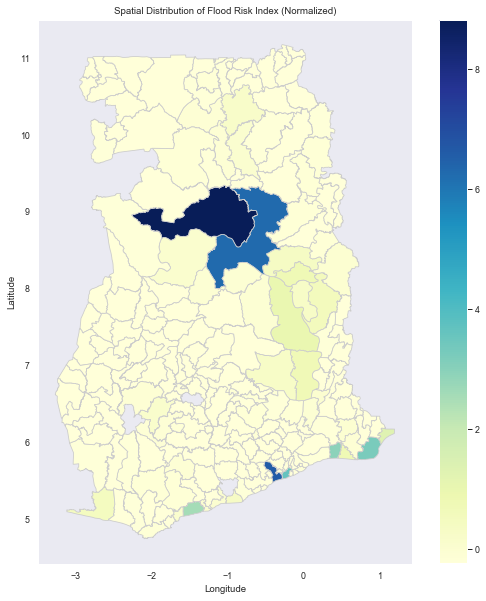

In [5]:
# map groups -----

import geopandas as gpd
import pandas as pd

sns.set_context("paper")
sns.set_style("dark")

# file paths and names
path_shp = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/Districts-Shapefiles/216distboufinal-v2.shp'

path_output = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/01-TC-Assignment/Perc-Flooded-NRT/Cropland/perc_cropland_flooded_shp/'
name_output_csv = 'perc_cropland_flooded.csv'
name_output_file = 'perc_cropland_flooded.shp'

# clean districts shapefile
ghana_dist = gpd.read_file(path_shp)
ghana_dist['DISTRICT'] = ghana_dist['DISTRICT'].str.title()

# map using geopandas
merged = ghana_dist.set_index('DISTRICT').join(tot_flood_risk.set_index('Region'))
merged.index.name = 'DISTRICT'
merged.reset_index(inplace=True)

merged = merged.sort_values(by=['Risk_Norm'], ascending=False)

# set a variable that will call whatever column we want to visualise on the map
variable = 'Risk_Norm'
colorscale = 'YlGnBu'

# set the range for the choropleth
vmin, vmax = min(merged[variable]), max(merged[variable])

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))

# create map
merged.plot(column=variable, cmap=colorscale, linewidth=0.8, ax=ax, edgecolor='0.8')
plt.title('Spatial Distribution of Flood Risk Index (Normalized)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

sm = plt.cm.ScalarMappable(cmap=colorscale, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

plt.show()


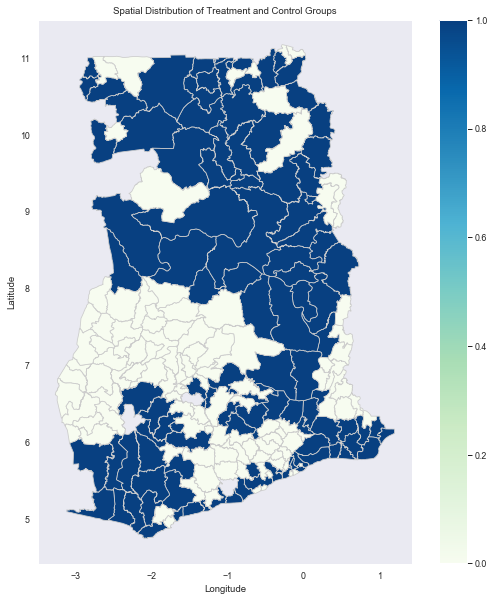

In [6]:
# map groups -----

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context('paper')
sns.set_style("dark")

# file paths and names
path_shp = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/00-Data-Sources/00-Cloud-to-Street/01-District-level/Districts-Shapefiles/216distboufinal-v2.shp'

path_output = '/Users/srilakshmi/Desktop/Thesis/04-Data-Analysis-Results/01-TC-Assignment/Perc-Flooded-NRT/Cropland/perc_cropland_flooded_shp/'
name_output_csv = 'perc_cropland_flooded.csv'
name_output_file = 'perc_cropland_flooded.shp'

# clean districts shapefile
ghana_dist = gpd.read_file(path_shp)
ghana_dist['DISTRICT'] = ghana_dist['DISTRICT'].str.title()

# map using geopandas
merged = ghana_dist.set_index('DISTRICT').join(tot_flood_risk.set_index('Region'))
merged.index.name = 'DISTRICT'
merged.reset_index(inplace=True)

merged = merged.sort_values(by=['Treatment'], ascending=False)

# set a variable that will call whatever column we want to visualise on the map
variable = 'Treatment'
colorscale = 'GnBu'

# set the range for the choropleth
vmin, vmax = min(merged[variable]), max(merged[variable])

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))

# create map
merged.plot(column=variable, cmap=colorscale, linewidth=0.8, ax=ax, edgecolor='0.8')
plt.title('Spatial Distribution of Treatment and Control Groups')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

sm = plt.cm.ScalarMappable(cmap=colorscale, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

plt.show()



Text(0.5, 0, 'Group (Control = 0, Treatment = 1)')

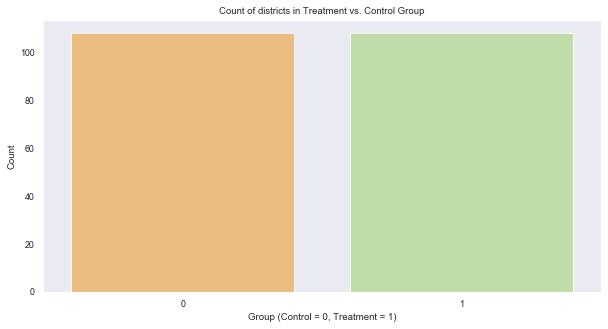

In [16]:
fig, ax = plt.subplots(figsize=(10,5)) # initialize figure and figure size

ax = sns.countplot(x="Treatment", data=tot_flood_risk,palette='Spectral')

plt.title('Count of districts in Treatment vs. Control Group')
plt.ylabel('Count')
plt.xlabel('Group (Control = 0, Treatment = 1)')
